In [1]:
## Part 1: Import Libraries and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)


In [2]:
#  Dataset Loader: Wine Quality

def load_wine_quality_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    df = pd.read_csv(url, sep=";")

    # Target: good_quality = 1 if quality > 5
    df["good_quality"] = (df["quality"] > 5).astype(int)
    y = df["good_quality"]
    X = df.drop(columns=["quality", "good_quality"])

    return train_test_split(X.values, y.values, test_size=0.3, stratify=y, random_state=42)


In [3]:
# Parameter Grids & Base Classifiers

param_grid_dt = {
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10]
}
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

dt_clf  = DecisionTreeClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
lr_clf  = LogisticRegression(random_state=42)

classifiers_to_tune = [
    (dt_clf,  param_grid_dt, 'Decision Tree'),
    (knn_clf, param_grid_knn, 'kNN'),
    (lr_clf,  param_grid_lr, 'Logistic Regression'),
]


In [4]:
#Manual Grid Search Implementation

from sklearn.base import clone

def run_manual_grid_search(X_train, y_train):
    print("Running Manual Grid Search...")
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    from itertools import product
    for clf, param_grid, name in classifiers_to_tune:
        best_score = -np.inf
        best_estimator = None
        keys, values = zip(*param_grid.items())

        for combo in product(*values):
            params = dict(zip(keys, combo))
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('select', SelectKBest(score_func=f_classif, k='all')),
                ('classifier', clone(clf))
            ])
            pipe.set_params(**params)

            scores = []
            for train_idx, val_idx in cv.split(X_train, y_train):
                pipe.fit(X_train[train_idx], y_train[train_idx])
                y_prob = pipe.predict_proba(X_train[val_idx])[:, 1]
                scores.append(roc_auc_score(y_train[val_idx], y_prob))

            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_estimator = pipe

        results[name] = {"best_estimator": best_estimator, "best_score": best_score}
        print(f"{name} Best CV AUC: {best_score:.4f}")
    return results


In [5]:
# Built-in GridSearchCV

def run_builtin_grid_search(X_train, y_train):
    print("Running Built-in GridSearchCV...")
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for clf, param_grid, name in classifiers_to_tune:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('select', SelectKBest(score_func=f_classif)),
            ('classifier', clf)
        ])
        grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)
        results[name] = {"best_estimator": grid.best_estimator_, "best_score": grid.best_score_}
        print(f"{name} Best CV AUC: {grid.best_score_:.4f}")
    return results


In [6]:
def evaluate_models(X_test, y_test, estimators, method_name):
    print(f"\nEvaluating {method_name} Models...")
    for name, model in estimators.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        print(f"\n{name}:")
        print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f" Precision: {precision_score(y_test, y_pred):.4f}")
        print(f" Recall: {recall_score(y_test, y_pred):.4f}")
        print(f" F1: {f1_score(y_test, y_pred):.4f}")
        print(f" ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    voting = VotingClassifier(estimators=[(n, m) for n, m in estimators.items()], voting='soft')
    voting.fit(X_test, y_test)
    y_pred = voting.predict(X_test)
    y_proba = voting.predict_proba(X_test)[:,1]

    print("\nVoting Classifier:")
    print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f" Precision: {precision_score(y_test, y_pred):.4f}")
    print(f" Recall: {recall_score(y_test, y_pred):.4f}")
    print(f" F1: {f1_score(y_test, y_pred):.4f}")
    print(f" ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
    plt.show()


Running Manual Grid Search...
Decision Tree Best CV AUC: 0.7718
kNN Best CV AUC: 0.8613
Logistic Regression Best CV AUC: 0.8051

Evaluating Manual Models...

Decision Tree:
 Accuracy: 0.7042
 Precision: 0.7366
 Recall: 0.6965
 F1: 0.7160
 ROC AUC: 0.7577

kNN:
 Accuracy: 0.7875
 Precision: 0.7839
 Recall: 0.8327
 F1: 0.8075
 ROC AUC: 0.8609

Logistic Regression:
 Accuracy: 0.7312
 Precision: 0.7462
 Recall: 0.7549
 F1: 0.7505
 ROC AUC: 0.8243

Voting Classifier:
 Accuracy: 0.9875
 Precision: 0.9922
 Recall: 0.9844
 F1: 0.9883
 ROC AUC: 0.9992


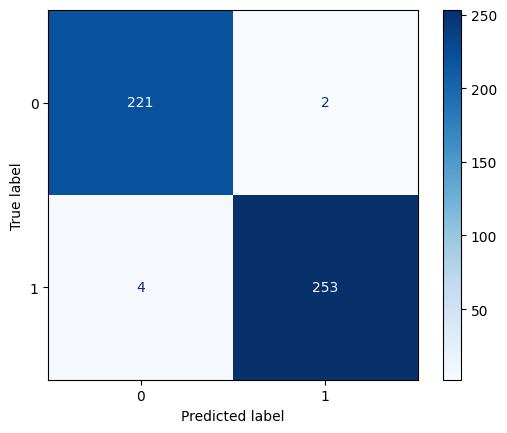

Running Built-in GridSearchCV...
Decision Tree Best CV AUC: 0.7690
kNN Best CV AUC: 0.8604
Logistic Regression Best CV AUC: 0.8048

Evaluating Built-in Models...

Decision Tree:
 Accuracy: 0.7271
 Precision: 0.7716
 Recall: 0.6965
 F1: 0.7321
 ROC AUC: 0.7927

kNN:
 Accuracy: 0.7854
 Precision: 0.7895
 Recall: 0.8171
 F1: 0.8031
 ROC AUC: 0.8690

Logistic Regression:
 Accuracy: 0.7417
 Precision: 0.7628
 Recall: 0.7510
 F1: 0.7569
 ROC AUC: 0.8247

Voting Classifier:
 Accuracy: 0.9688
 Precision: 0.9802
 Recall: 0.9611
 F1: 0.9705
 ROC AUC: 0.9971


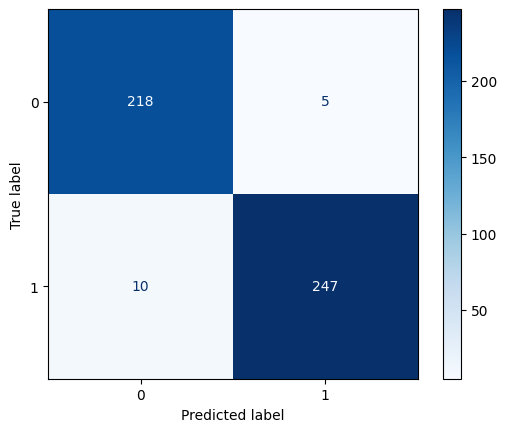

In [7]:
X_train, X_test, y_train, y_test = load_wine_quality_dataset()

# Manual
manual = run_manual_grid_search(X_train, y_train)
evaluate_models(X_test, y_test, {n:r["best_estimator"] for n,r in manual.items()}, "Manual")

# Built-in
builtin = run_builtin_grid_search(X_train, y_train)
evaluate_models(X_test, y_test, {n:r["best_estimator"] for n,r in builtin.items()}, "Built-in")
